In [3]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import timeit
from rpl import RadarSignalProcessing
import sys
from DBReader.DBReader import SyncReader

## 1. Load the dataset

In [51]:
root_folder = '/Volumes/ELEMENTS/datasets/radial/RECORD@2020-11-22_12.45.05'
db = SyncReader(root_folder,tolerance=20000)

-------------------------------------------------------------------------
- Sensors available:
-     radar_ch2
-     camera
-     radar_ch1
-     radar_ch0
-     can
-     gps
-     radar_ch3
-     scala
-
- You might use function "setSensorFilters" to select sensors you want to read!
-------------------------------------------------------------------------
Total tolerance errors:  18.314606741573034 %
Total corrupted frames:  1.1235955056179776 %


In [52]:
# use print_info function to get all the details of the database content
db.print_info()
print('')

# Create an iterator on the dataset
ite = iter(db)

Available sensors:
# Sensor:  radar_ch2
	- filename:  /Volumes/ELEMENTS/datasets/radial/RECORD@2020-11-22_12.45.05/RECORD@2020-11-22_12.45.05_radar_ch2.bin
	- Nb Samples:  5583
	- Duration:  178 sec
	- Update rate:  31.92029374888053 ms
# Sensor:  camera
	- filename:  /Volumes/ELEMENTS/datasets/radial/RECORD@2020-11-22_12.45.05/RECORD@2020-11-22_12.45.05_camera.mjpg
	- Nb Samples:  8088
	- Duration:  178 sec
	- Update rate:  22.052941641938677 ms
# Sensor:  radar_ch1
	- filename:  /Volumes/ELEMENTS/datasets/radial/RECORD@2020-11-22_12.45.05/RECORD@2020-11-22_12.45.05_radar_ch1.bin
	- Nb Samples:  5584
	- Duration:  178 sec
	- Update rate:  31.91421919770774 ms
# Sensor:  radar_ch0
	- filename:  /Volumes/ELEMENTS/datasets/radial/RECORD@2020-11-22_12.45.05/RECORD@2020-11-22_12.45.05_radar_ch0.bin
	- Nb Samples:  5582
	- Duration:  178 sec
	- Update rate:  31.926549623790752 ms
# Sensor:  can
	- filename:  /Volumes/ELEMENTS/datasets/radial/RECORD@2020-11-22_12.45.05/RECORD@2020-11-22_12.4

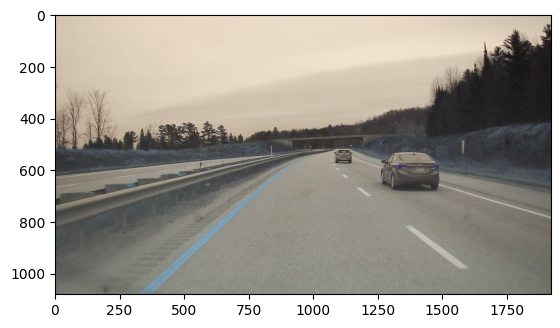

In [8]:
sample = db.GetSensorData(68)
plt.imshow(sample['camera']['data'])

## 2. RadarSignalProcessing to compute Point Cloud 

In [14]:
CALIB_PATH = '/Volumes/ELEMENTS/datasets/radial/CalibrationTable.npy'

In [15]:
RSP = RadarSignalProcessing(CALIB_PATH, method='PC')

CPU will be used to execute the processing


In [16]:
%time pc=RSP.run(sample['radar_ch0']['data'],sample['radar_ch1']['data'],sample['radar_ch2']['data'],sample['radar_ch3']['data'])

TypeError: sum() received an invalid combination of arguments - got (out=NoneType, axis=int, ), but expected one of:
 * (*, torch.dtype dtype = None)
      didn't match because some of the keywords were incorrect: out, axis
 * (tuple of ints dim, bool keepdim = False, *, torch.dtype dtype = None)
 * (tuple of names dim, bool keepdim = False, *, torch.dtype dtype = None)


In [17]:
# PC = [Range,Doppler,Azimuth,Elevation]
Az = pc[:,2]
R = pc[:,0]
plt.figure(figsize=(10,10))
plt.polar(Az,R,'.')

NameError: name 'pc' is not defined

## 3. RadarSignalProcessing to compute Doppler Spectrums

In [19]:
RSP = RadarSignalProcessing(CALIB_PATH, method='RD')

CPU will be used to execute the processing


In [20]:
%time rd=RSP.run(sample['radar_ch0']['data'],sample['radar_ch1']['data'],sample['radar_ch2']['data'],sample['radar_ch3']['data'])

CPU times: user 109 ms, sys: 94 ms, total: 203 ms
Wall time: 104 ms


torch.Size([512, 256, 16]) It has 16 channels, one for each Rx antenna


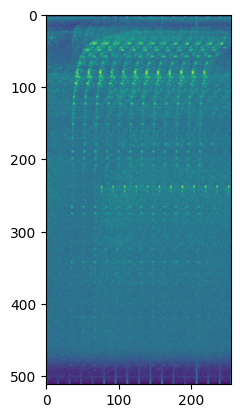

In [22]:
print(rd.shape,'It has 16 channels, one for each Rx antenna')
plt.imshow(np.log10(np.sum(np.abs(rd.cpu().numpy()), axis=2)))

# 3.1 View Individual Channels
To check if specific antennas have stronger or cleaner signals:

/var/folders/wh/181dmx3d2v94m8cyv4ny1s_w0000gn/T/ipykernel_43624/2807305757.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.log10(np.abs(rd[:, :, i]) + 1e-6), aspect='auto')


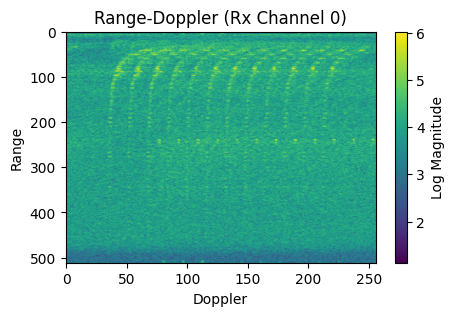

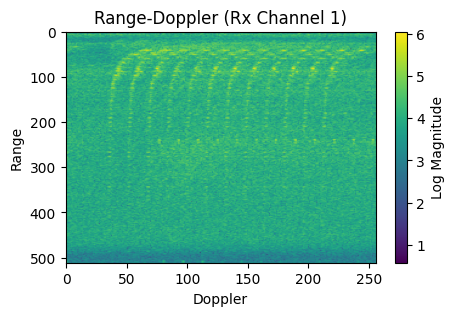

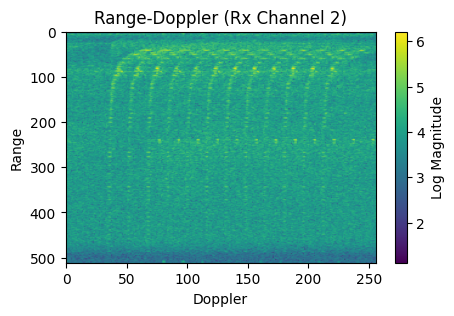

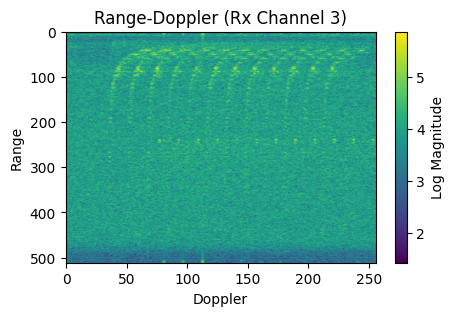

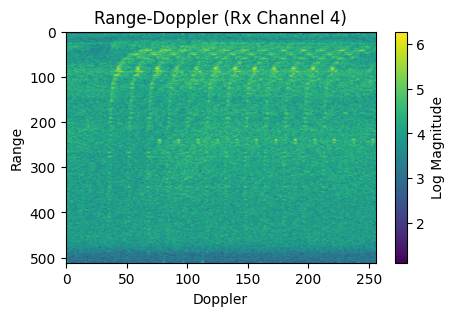

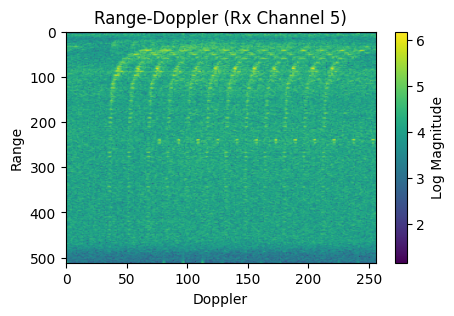

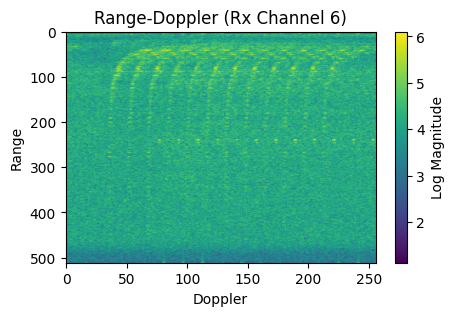

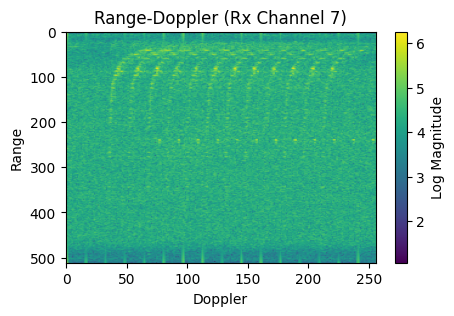

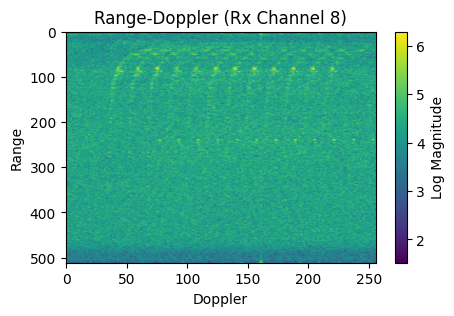

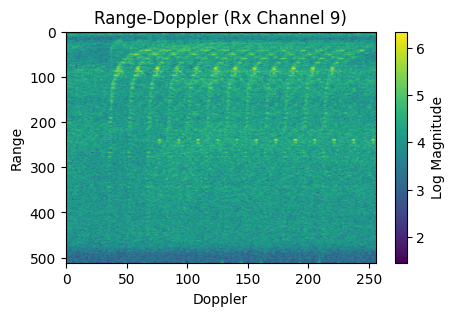

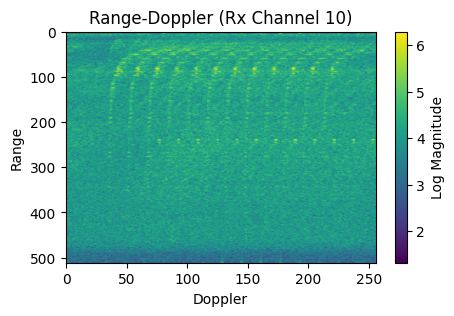

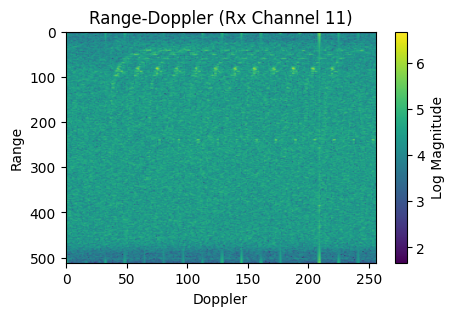

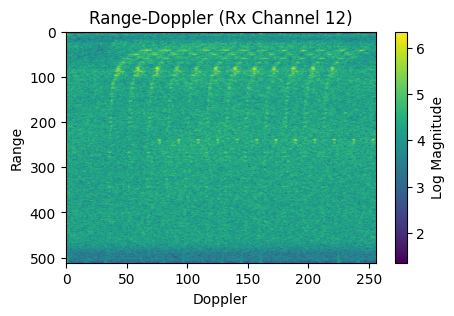

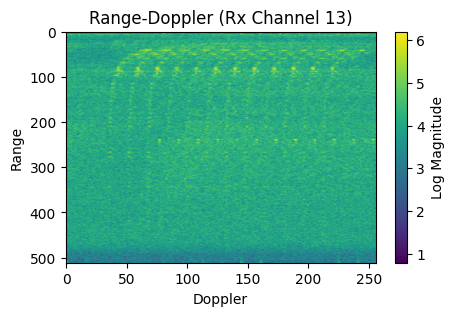

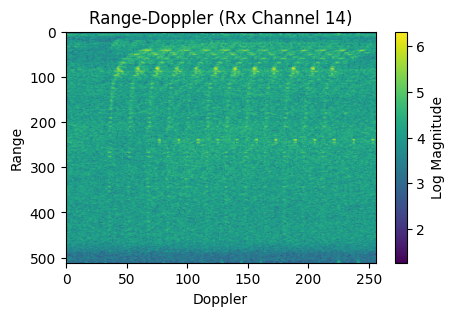

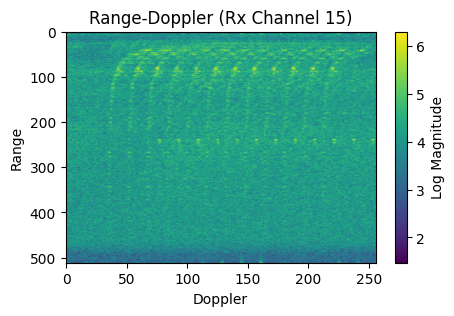

In [25]:
for i in range(rd.shape[2]):
    plt.figure(figsize=(5, 3))
    plt.imshow(np.log10(np.abs(rd[:, :, i]) + 1e-6), aspect='auto')
    plt.title(f'Range-Doppler (Rx Channel {i})')
    plt.xlabel('Doppler')
    plt.ylabel('Range')
    plt.colorbar(label='Log Magnitude')
    plt.show()

# 3.2. Principal Component Projection (PCA across channels)
This can reveal dominant motion patterns across antennas PCA is useful if you want to reduce the dimensionality and capture the most significant variance across channels:


/var/folders/wh/181dmx3d2v94m8cyv4ny1s_w0000gn/T/ipykernel_43624/680875318.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  principal_component = pca.fit_transform(np.abs(rd_flat))


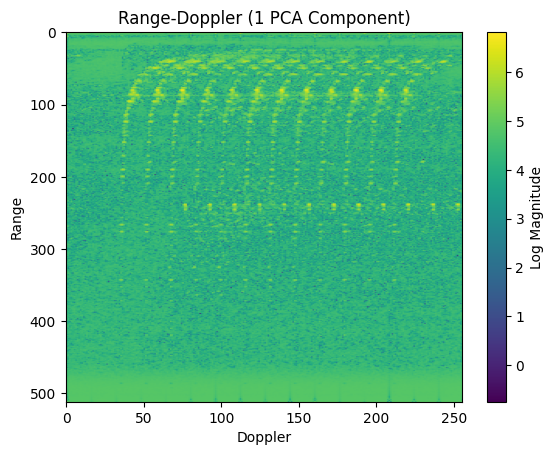

In [38]:
from sklearn.decomposition import PCA

# Flatten Range-Doppler into a 2D matrix: (num_pixels, num_channels)
rd_flat = rd.reshape(-1, rd.shape[2])
components = 1
pca = PCA(n_components=components)
principal_component = pca.fit_transform(np.abs(rd_flat))

# Reshape back to 2D image
# Reshape back to 2D for visualization (range x doppler x components)
pca_image = principal_component.reshape(512, 256, components)
# pc_image = principal_component.reshape(rd.shape[0], rd.shape[1])

plt.imshow(np.log10(np.abs(pca_image) + 1e-6), aspect='auto')
plt.title(f'Range-Doppler ({components} PCA Component)')
plt.xlabel('Doppler')
plt.ylabel('Range')
plt.colorbar(label='Log Magnitude')
plt.show()

# 3.3. Complex Coherent Sum (Phase-Sensitive)
This keeps phase info and might emphasize directional targets:

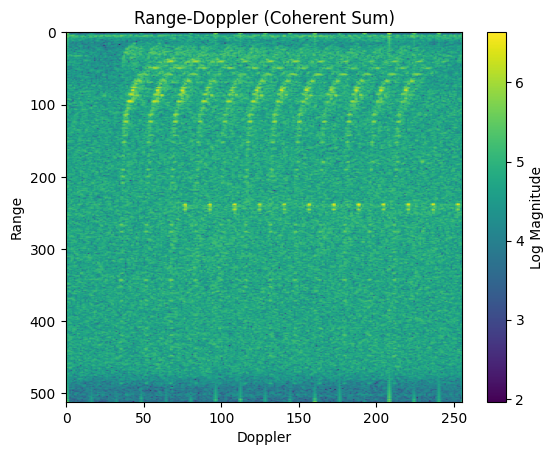

In [40]:
coherent_sum = np.sum(rd.numpy(), axis=2)  # Complex sum across Rx antennas
plt.imshow(np.log10(np.abs(coherent_sum) + 1e-6), aspect='auto')
plt.title('Range-Doppler (Coherent Sum)')
plt.xlabel('Doppler')
plt.ylabel('Range')
plt.colorbar(label='Log Magnitude')
plt.show()

# 3.4. Background Subtraction (Clutter Removal)
To highlight moving targets:

/var/folders/wh/181dmx3d2v94m8cyv4ny1s_w0000gn/T/ipykernel_43624/741880381.py:11: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(np.sum(rd_detrended, axis=2) + 1e-6),


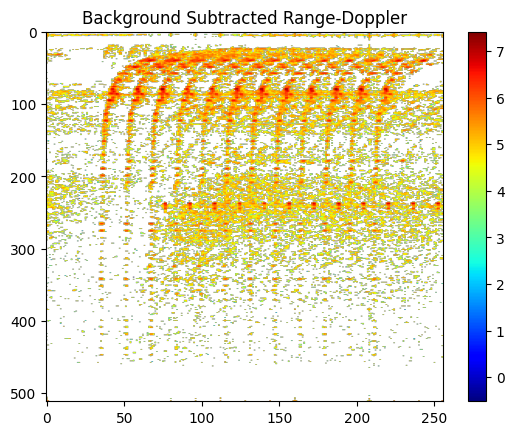

In [45]:
# rd = rd.cpu().numpy()  # Convert to numpy for further processing
# Mean across slow time (or if you have a time dimension, use that instead)
# Average over a portion of the data to estimate background
# Mean across range and doppler bins
background = np.mean(np.abs(rd), axis=(0, 1))

# Subtract background from each channel
rd_detrended = np.abs(rd) - background.reshape(1, 1, 16)

# Visualize the result
plt.imshow(np.log10(np.sum(rd_detrended, axis=2) + 1e-6),
           aspect='auto', cmap='jet')
plt.title('Background Subtracted Range-Doppler')
plt.colorbar()
plt.show()

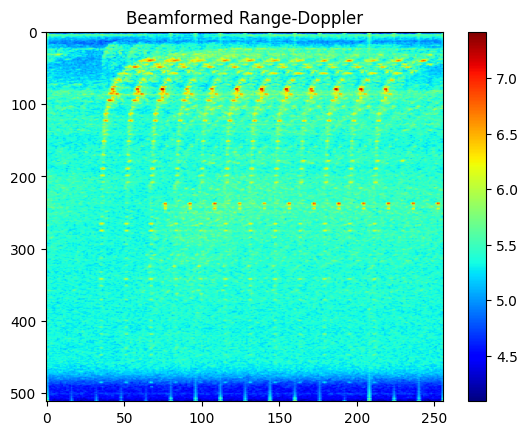

In [48]:
# Example beamforming by averaging channels with a directional delay (simple)
# You can extend this to more sophisticated beamforming techniques.
directional_sum = np.sum(np.abs(rd), axis=2)  # Simple sum over all channels
rd_bf = directional_sum
plt.imshow(np.log10(directional_sum + 1e-6), aspect='auto', cmap='jet')
plt.title('Beamformed Range-Doppler')
plt.colorbar()
plt.show()

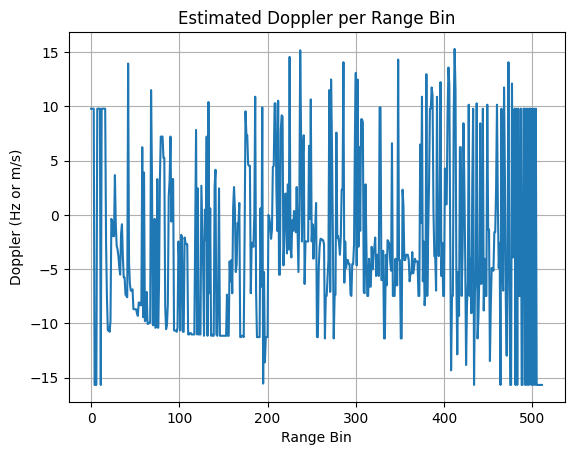

In [55]:
# Assuming `rd_bf` is your beamformed Range-Doppler map (magnitude or power)
# Optional: convert to Hz or m/s
doppler_bin_time = 0.03192  # seconds (31.92 ms)
num_doppler_bins = rd_bf.shape[1]
doppler_axis = np.fft.fftshift(np.fft.fftfreq(
    num_doppler_bins, d=doppler_bin_time))

# Example for 77 GHz radar (λ ≈ 3.9 mm)
fc = 77e9  # carrier frequency in Hz
c = 3e8    # speed of light in m/s
lambda_radar = c / fc

doppler_velocity_axis = doppler_axis * lambda_radar / 2

# Index of max Doppler per range
true_doppler_indices = np.argmax(rd_bf, axis=1)
true_doppler_values = doppler_axis[true_doppler_indices]
true_doppler_velocity = doppler_velocity_axis[true_doppler_indices]  # m/s


# Plot range vs. true Doppler value
plt.plot(true_doppler_values)
plt.title("Estimated Doppler per Range Bin")
plt.xlabel("Range Bin")
plt.ylabel("Doppler (Hz or m/s)")
plt.grid()
plt.show()

In [66]:
# Compute Doppler Spectrum for a Single Channel
numerator = np.sum(rd_bf * doppler_axis[None, :], axis=1)
denominator = np.sum(rd_bf + 1e-8, axis=1)
doppler_centroids = numerator / denominator


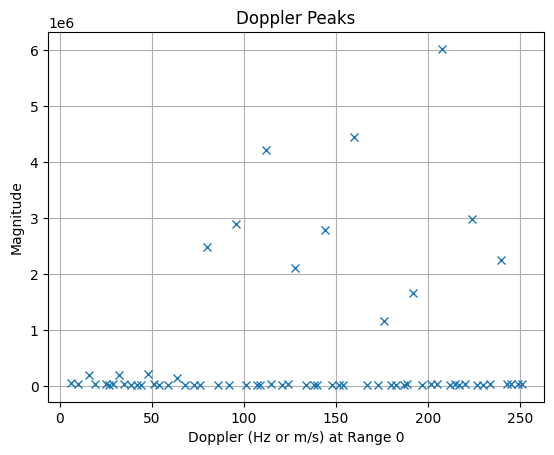

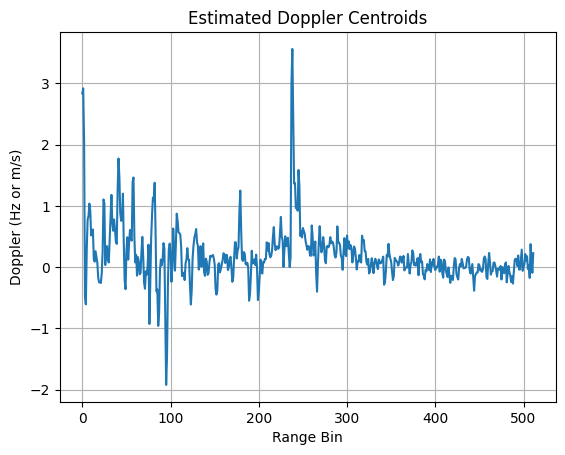

In [67]:
from scipy.signal import find_peaks
threshold = 0.1
for r in range(rd_bf.shape[0]):
    peaks, _ = find_peaks(rd_bf[r, :], height=threshold)  # tune threshold
    true_dopplers = doppler_axis[peaks]
    # Optionally store or plot
# # plot
# plt.plot(doppler_axis, rd_bf[0, :])
# plt.title("Range 0 Doppler Spectrum")

# plot true_dopplers
plt.plot(peaks, rd_bf[0, peaks], "x")
plt.xlabel("Doppler (Hz or m/s) at Range 0")
plt.ylabel("Magnitude")
plt.title("Doppler Peaks")
plt.grid()
plt.show()
# Plot the estimated Doppler centroids
plt.plot(doppler_centroids)
plt.title("Estimated Doppler Centroids")
plt.xlabel("Range Bin")
plt.ylabel("Doppler (Hz or m/s)")
plt.grid()

## 4. RadarSignalProcessing to compute Range-Azimuth map

### 4.1 Using CuPy

In [10]:
RSP = RadarSignalProcessing('CalibrationTable.npy',method='RA',device='cuda',lib='CuPy')

CuPy on GPU will be used to execute the processing


In [11]:
%time ra=RSP.run(sample['radar_ch0']['data'],sample['radar_ch1']['data'],sample['radar_ch2']['data'],sample['radar_ch3']['data'])

CPU times: user 1.86 s, sys: 236 ms, total: 2.1 s
Wall time: 1.01 s


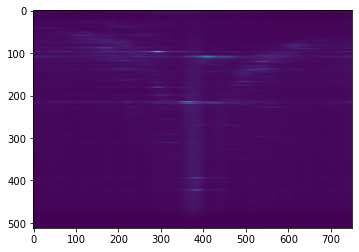

In [12]:
plt.imshow(ra)

### 4.2 Using PyTorch

In [13]:
RSP = RadarSignalProcessing('CalibrationTable.npy',method='RA',device='cuda',lib='PyTorch')

PyTorch on GPU will be used to execute the processing


In [14]:
%time ra=RSP.run(sample['radar_ch0']['data'],sample['radar_ch1']['data'],sample['radar_ch2']['data'],sample['radar_ch3']['data'])

CPU times: user 1.58 s, sys: 104 ms, total: 1.69 s
Wall time: 384 ms


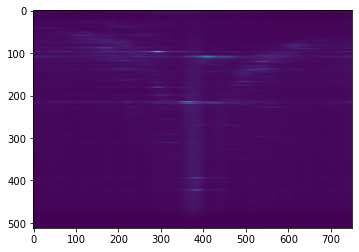

In [15]:
plt.imshow(ra)

### 4.3 Using CPU

In [16]:
RSP = RadarSignalProcessing('CalibrationTable.npy',method='RA',device='cpu')

CPU will be used to execute the processing


In [17]:
%time ra=RSP.run(sample['radar_ch0']['data'],sample['radar_ch1']['data'],sample['radar_ch2']['data'],sample['radar_ch3']['data'])

CPU times: user 6.72 s, sys: 2.03 s, total: 8.75 s
Wall time: 3.42 s


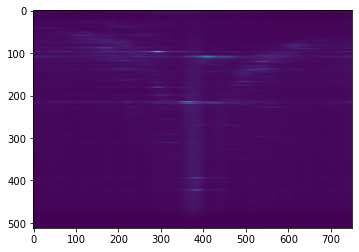

In [18]:
plt.imshow(ra)